In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load and Prepare Data

In [2]:
# Load the consolidated dataset
data_path = Path('../data/processed/ppr_consolidated.parquet')
df = pd.read_parquet(data_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Date range: {df['sale_date'].min()} to {df['sale_date'].max()}")

Dataset loaded successfully!
Shape: (752907, 12)
Date range: 2010-01-01 00:00:00 to 2025-11-07 00:00:00


In [3]:
# Examine property_description field
print("Property Description Values:")
print(df['property_description'].value_counts())
print(f"\nTotal unique values: {df['property_description'].nunique()}")

Property Description Values:
property_description
Second-Hand Dwelling house /Apartment    622242
New Dwelling house /Apartment            130617
Teach/Árasán Cónaithe Atháimhe               44
Teach/Árasán Cónaithe Nua                     3
Teach/?ras?n C?naithe Nua                     1
Name: count, dtype: int64

Total unique values: 5


In [4]:
# Classify properties as New or Second-Hand
# New builds typically indicated by "New" or "Newbuild" in description or VAT exclusive

def classify_property_type(row):
    """
    Classify property as New Build or Second-Hand
    
    Logic:
    - VAT Exclusive typically indicates new build (commercial new property)
    - Property description containing 'New' indicates new build
    - Otherwise, second-hand
    """
    desc = str(row['property_description']).upper()
    
    # Check if VAT exclusive (strong indicator of new build)
    if row['vat_exclusive'] == True:
        return 'New Build'
    
    # Check description for 'NEW'
    if 'NEW' in desc:
        return 'New Build'
    
    return 'Second-Hand'

df['property_type'] = df.apply(classify_property_type, axis=1)

print("Property Type Classification:")
print(df['property_type'].value_counts())
print(f"\nNew Build percentage: {(df['property_type'] == 'New Build').sum() / len(df) * 100:.2f}%")

Property Type Classification:
property_type
Second-Hand    622286
New Build      130621
Name: count, dtype: int64

New Build percentage: 17.35%


## 2. Price Comparison: New vs Second-Hand

In [5]:
# Overall price statistics by property type
price_stats = df.groupby('property_type')['price_eur'].agg([
    'count', 'mean', 'median', 'std', 
    ('q25', lambda x: x.quantile(0.25)),
    ('q75', lambda x: x.quantile(0.75))
]).round(2)

price_stats.columns = ['Count', 'Mean', 'Median', 'Std Dev', 'Q25', 'Q75']

print("\n=== Price Statistics by Property Type ===")
print(price_stats)

# Calculate premium
new_mean = price_stats.loc['New Build', 'Mean']
sh_mean = price_stats.loc['Second-Hand', 'Mean']
premium_pct = ((new_mean - sh_mean) / sh_mean) * 100

print(f"\nNew Build Price Premium: {premium_pct:.2f}%")
print(f"Absolute difference: €{new_mean - sh_mean:,.2f}")


=== Price Statistics by Property Type ===
                Count      Mean    Median    Std Dev       Q25       Q75
property_type                                                           
New Build      130621 402181.19 295155.00 2302337.29 210000.00 387665.00
Second-Hand    622286 290576.32 220000.00  755127.42 130000.00 345000.00

New Build Price Premium: 38.41%
Absolute difference: €111,604.87


/tmp/ipykernel_127528/2274929281.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df_filtered[df_filtered['property_type'] == 'New Build']['price_eur'].dropna(),


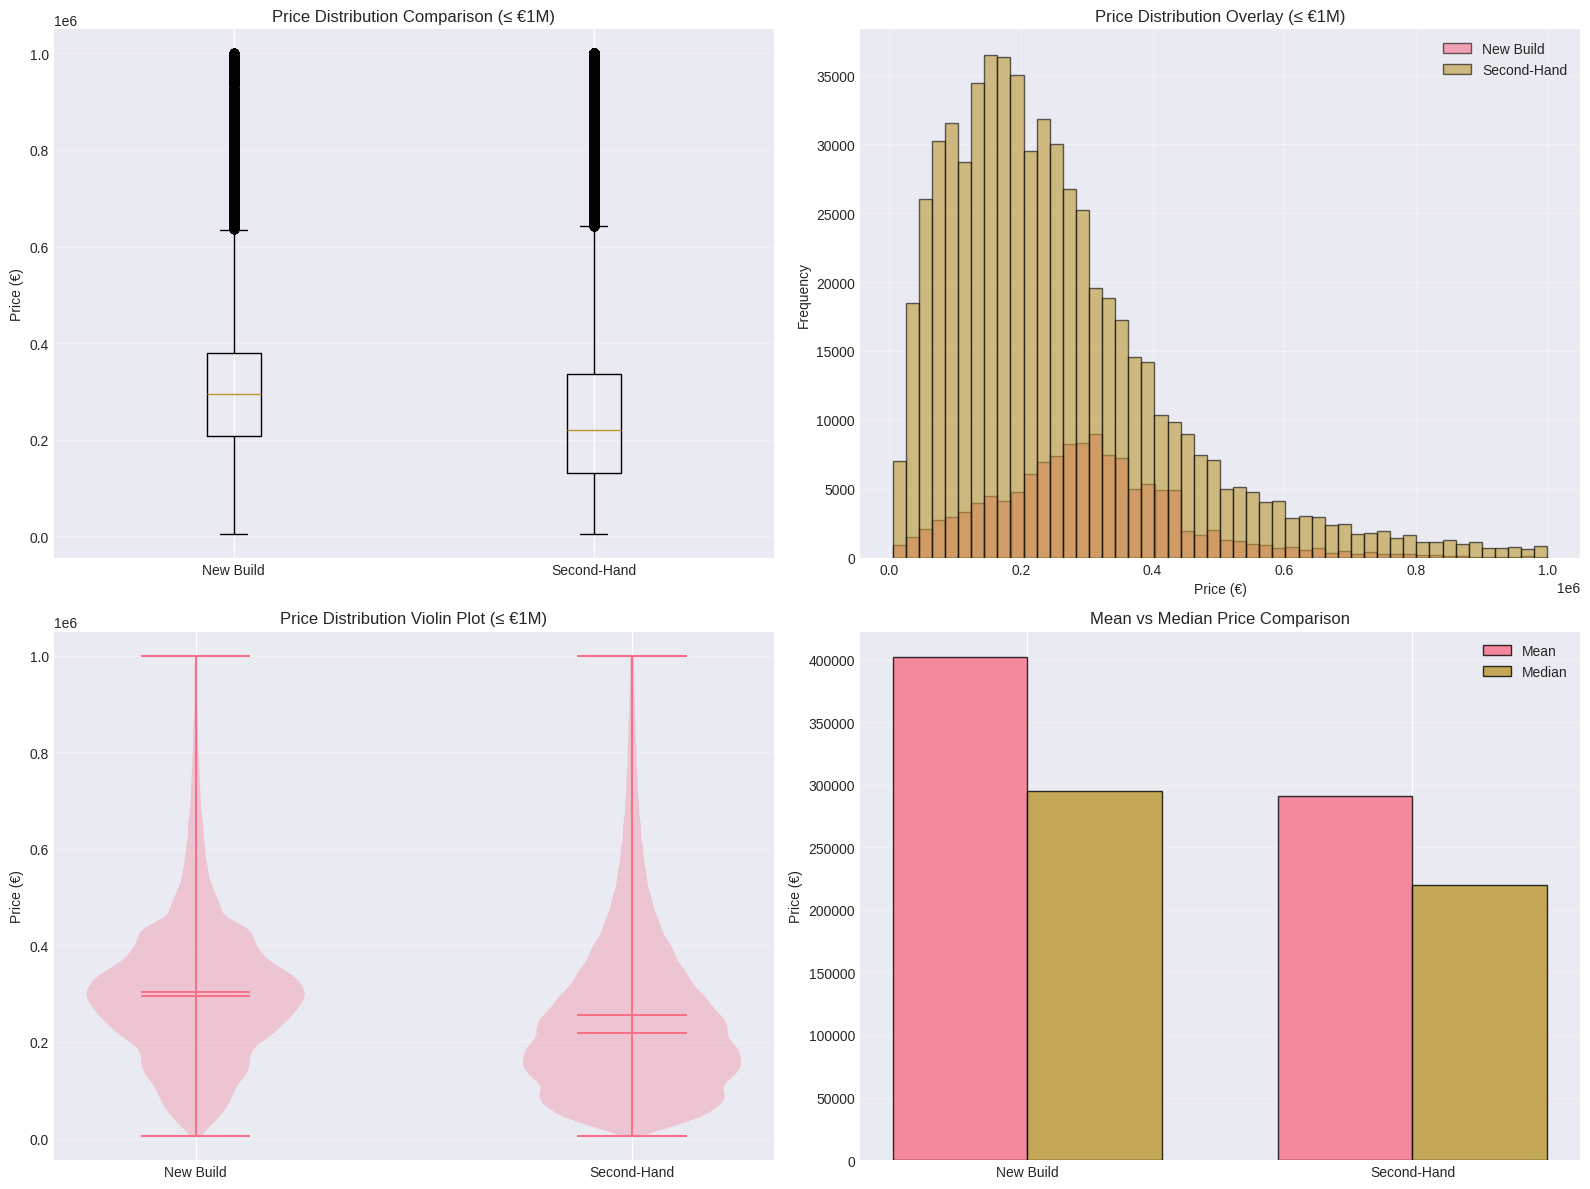

In [6]:
# Visualize price distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Box plot comparison (filter outliers for better viz)
df_filtered = df[df['price_eur'] <= 1000000].copy()
axes[0, 0].boxplot([df_filtered[df_filtered['property_type'] == 'New Build']['price_eur'].dropna(),
                     df_filtered[df_filtered['property_type'] == 'Second-Hand']['price_eur'].dropna()],
                    labels=['New Build', 'Second-Hand'])
axes[0, 0].set_ylabel('Price (€)')
axes[0, 0].set_title('Price Distribution Comparison (≤ €1M)')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Histogram overlay
new_prices = df_filtered[df_filtered['property_type'] == 'New Build']['price_eur'].dropna()
sh_prices = df_filtered[df_filtered['property_type'] == 'Second-Hand']['price_eur'].dropna()

axes[0, 1].hist(new_prices, bins=50, alpha=0.6, label='New Build', edgecolor='black')
axes[0, 1].hist(sh_prices, bins=50, alpha=0.6, label='Second-Hand', edgecolor='black')
axes[0, 1].set_xlabel('Price (€)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Price Distribution Overlay (≤ €1M)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Violin plot
parts = axes[1, 0].violinplot([new_prices, sh_prices], positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 0].set_xticks([1, 2])
axes[1, 0].set_xticklabels(['New Build', 'Second-Hand'])
axes[1, 0].set_ylabel('Price (€)')
axes[1, 0].set_title('Price Distribution Violin Plot (≤ €1M)')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Mean/Median comparison bar chart
x = np.arange(2)
width = 0.35

means = [price_stats.loc['New Build', 'Mean'], price_stats.loc['Second-Hand', 'Mean']]
medians = [price_stats.loc['New Build', 'Median'], price_stats.loc['Second-Hand', 'Median']]

axes[1, 1].bar(x - width/2, means, width, label='Mean', alpha=0.8, edgecolor='black')
axes[1, 1].bar(x + width/2, medians, width, label='Median', alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('Price (€)')
axes[1, 1].set_title('Mean vs Median Price Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(['New Build', 'Second-Hand'])
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Temporal Analysis: Trends Over Time

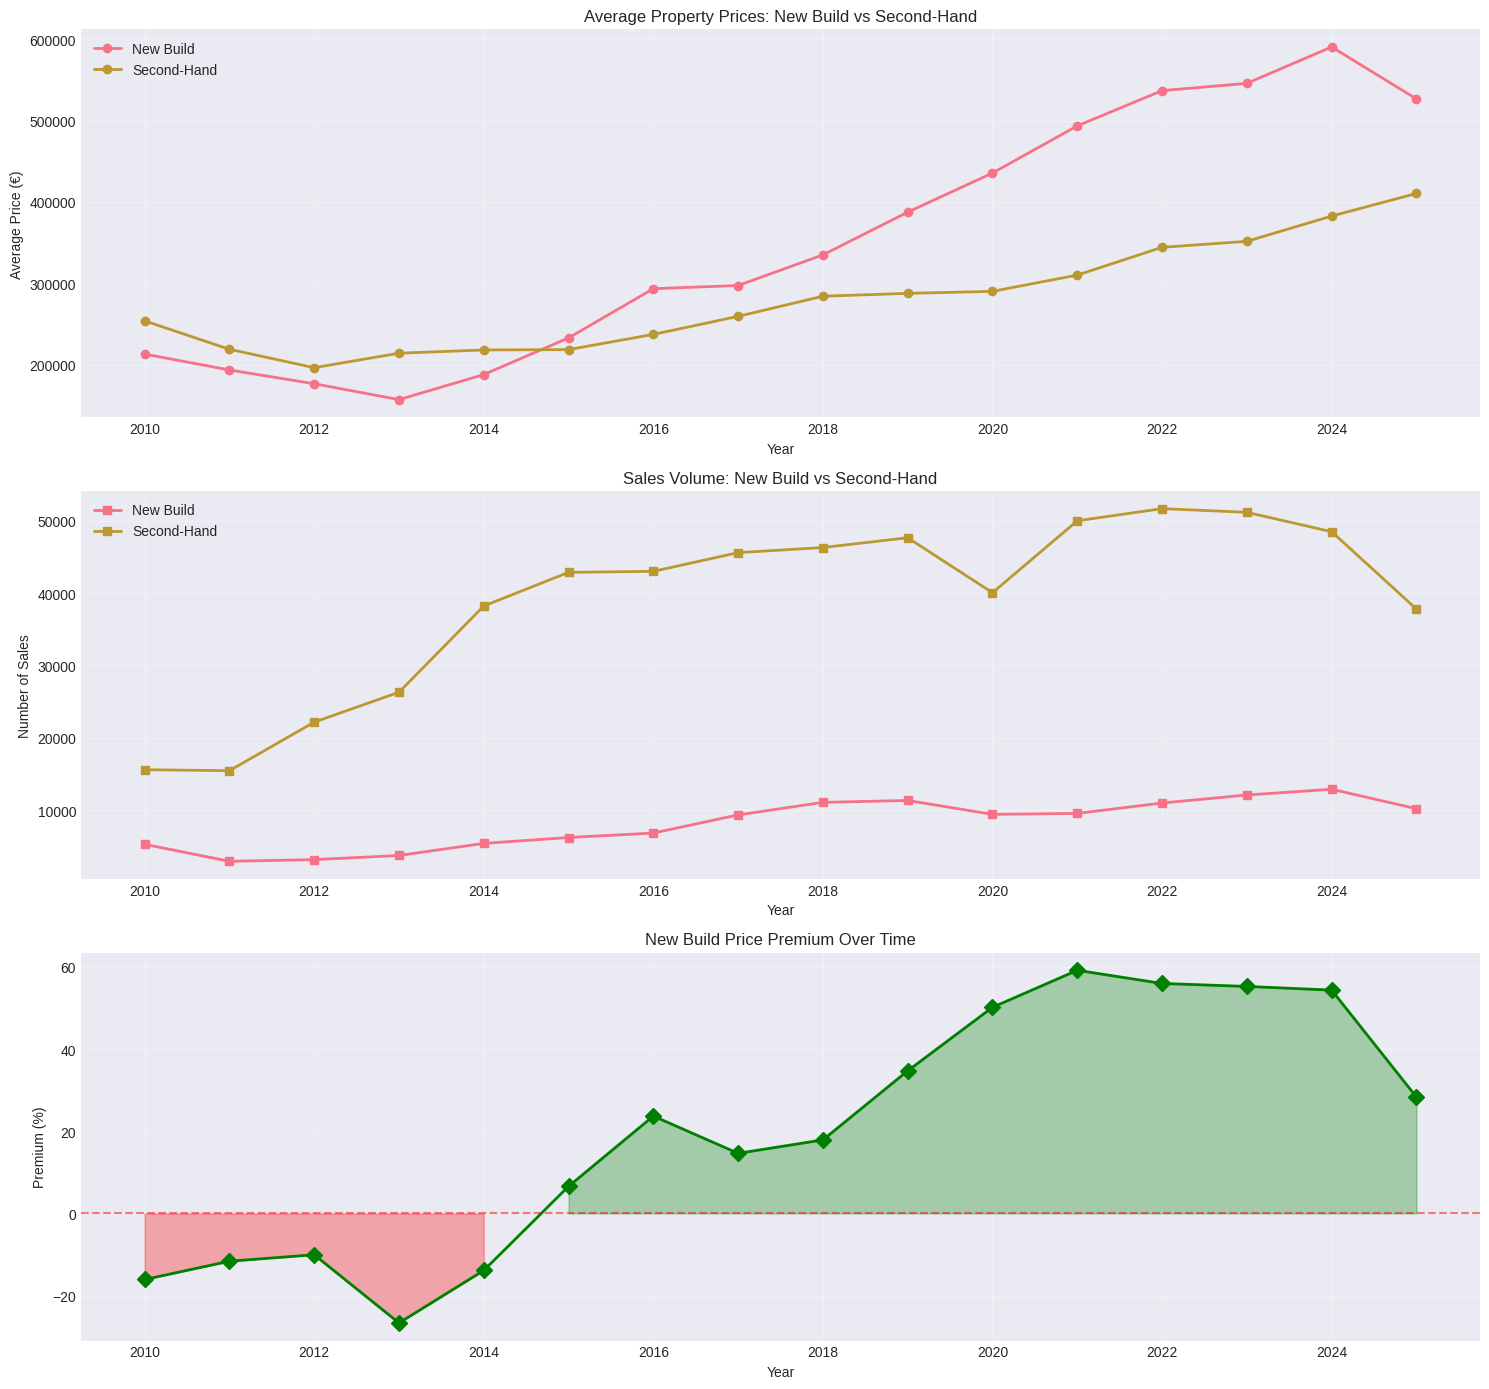


Yearly Premium Statistics:
property_type  New Build  Second-Hand  Premium_Pct
year                                              
2010           212902.30    253720.12       -16.09
2011           193333.69    218803.46       -11.64
2012           176413.80    196153.54       -10.06
2013           156901.26    213958.88       -26.67
2014           187705.99    217965.75       -13.88
2015           232799.75    218417.95         6.58
2016           293292.20    237108.30        23.70
2017           297208.23    259281.57        14.63
2018           334898.52    284059.31        17.90
2019           387409.73    287578.84        34.71
2020           435544.51    290026.56        50.17
2021           493527.42    310039.52        59.18
2022           536864.27    344195.26        55.98
2023           545811.98    351550.69        55.26
2024           590563.76    382589.08        54.36
2025           526702.86    410431.28        28.33


In [7]:
# Yearly price trends by property type
yearly_trends = df.groupby(['year', 'property_type'])['price_eur'].agg(['mean', 'median', 'count']).reset_index()

fig, axes = plt.subplots(3, 1, figsize=(15, 14))

# 1. Average price over time
for ptype in ['New Build', 'Second-Hand']:
    data = yearly_trends[yearly_trends['property_type'] == ptype]
    axes[0].plot(data['year'], data['mean'], marker='o', linewidth=2, label=ptype)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Average Price (€)')
axes[0].set_title('Average Property Prices: New Build vs Second-Hand')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Sales volume over time
for ptype in ['New Build', 'Second-Hand']:
    data = yearly_trends[yearly_trends['property_type'] == ptype]
    axes[1].plot(data['year'], data['count'], marker='s', linewidth=2, label=ptype)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Sales')
axes[1].set_title('Sales Volume: New Build vs Second-Hand')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3. Price premium evolution
premium_by_year = yearly_trends.pivot(index='year', columns='property_type', values='mean')
premium_by_year['Premium_Pct'] = ((premium_by_year['New Build'] - premium_by_year['Second-Hand']) / 
                                   premium_by_year['Second-Hand']) * 100

axes[2].plot(premium_by_year.index, premium_by_year['Premium_Pct'], marker='D', 
             linewidth=2, color='green', markersize=8)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Premium (%)')
axes[2].set_title('New Build Price Premium Over Time')
axes[2].grid(alpha=0.3)
axes[2].fill_between(premium_by_year.index, 0, premium_by_year['Premium_Pct'], 
                      where=(premium_by_year['Premium_Pct'] >= 0), alpha=0.3, color='green')
axes[2].fill_between(premium_by_year.index, 0, premium_by_year['Premium_Pct'], 
                      where=(premium_by_year['Premium_Pct'] < 0), alpha=0.3, color='red')

plt.tight_layout()
plt.show()

print("\nYearly Premium Statistics:")
print(premium_by_year[['New Build', 'Second-Hand', 'Premium_Pct']].round(2))

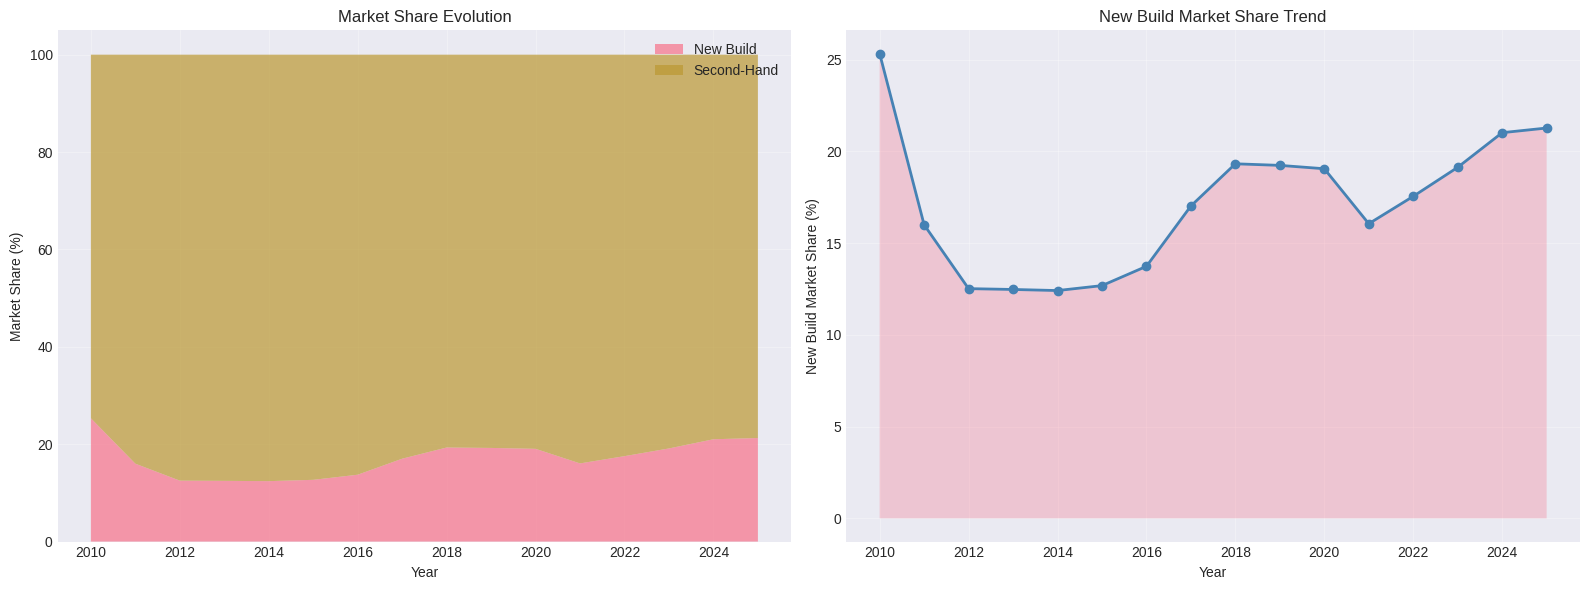


Market Share by Year:
property_type  New Build  Second-Hand
year                                 
2010               25.33        74.67
2011               16.00        84.00
2012               12.52        87.48
2013               12.47        87.53
2014               12.41        87.59
2015               12.68        87.32
2016               13.73        86.27
2017               17.02        82.98
2018               19.32        80.68
2019               19.23        80.77
2020               19.05        80.95
2021               16.05        83.95
2022               17.55        82.45
2023               19.13        80.87
2024               21.02        78.98
2025               21.27        78.73


In [8]:
# Market share over time
market_share = df.groupby(['year', 'property_type']).size().unstack(fill_value=0)
market_share_pct = market_share.div(market_share.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Stacked area chart
axes[0].stackplot(market_share_pct.index, 
                  market_share_pct['New Build'], 
                  market_share_pct['Second-Hand'],
                  labels=['New Build', 'Second-Hand'],
                  alpha=0.7)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Market Share (%)')
axes[0].set_title('Market Share Evolution')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Line chart of new build percentage
axes[1].plot(market_share_pct.index, market_share_pct['New Build'], 
             marker='o', linewidth=2, color='steelblue')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('New Build Market Share (%)')
axes[1].set_title('New Build Market Share Trend')
axes[1].grid(alpha=0.3)
axes[1].fill_between(market_share_pct.index, 0, market_share_pct['New Build'], alpha=0.3)

plt.tight_layout()
plt.show()

print("\nMarket Share by Year:")
print(market_share_pct.round(2))

## 4. County Analysis: New Build Activity

In [9]:
# New build activity by county
county_analysis = df.groupby(['county', 'property_type']).agg({
    'price_eur': ['count', 'mean', 'median']
}).round(2)

county_analysis.columns = ['_'.join(col).strip() for col in county_analysis.columns.values]
county_analysis = county_analysis.reset_index()

# Pivot for easier analysis
county_pivot = county_analysis.pivot(index='county', columns='property_type')

# Calculate new build percentage
new_counts = county_pivot[('price_eur_count', 'New Build')].fillna(0)
total_counts = county_pivot['price_eur_count'].sum(axis=1)
new_build_pct = (new_counts / total_counts * 100).sort_values(ascending=False)

print("\nTop 10 Counties by New Build Activity:")
print(new_build_pct.head(10))

print("\nBottom 10 Counties by New Build Activity:")
print(new_build_pct.tail(10))


Top 10 Counties by New Build Activity:
county
Kildare    33.67
Meath      30.28
Wicklow    26.85
Louth      23.26
Laois      20.17
Cork       18.94
Dublin     17.60
Wexford    15.31
Carlow     14.93
Kilkenny   14.55
dtype: float64

Bottom 10 Counties by New Build Activity:
county
Cavan       12.28
Leitrim     12.10
Limerick    11.91
Donegal     10.33
Clare        9.90
Roscommon    9.87
Kerry        9.72
Longford     9.12
Mayo         8.86
Tipperary    7.83
dtype: float64


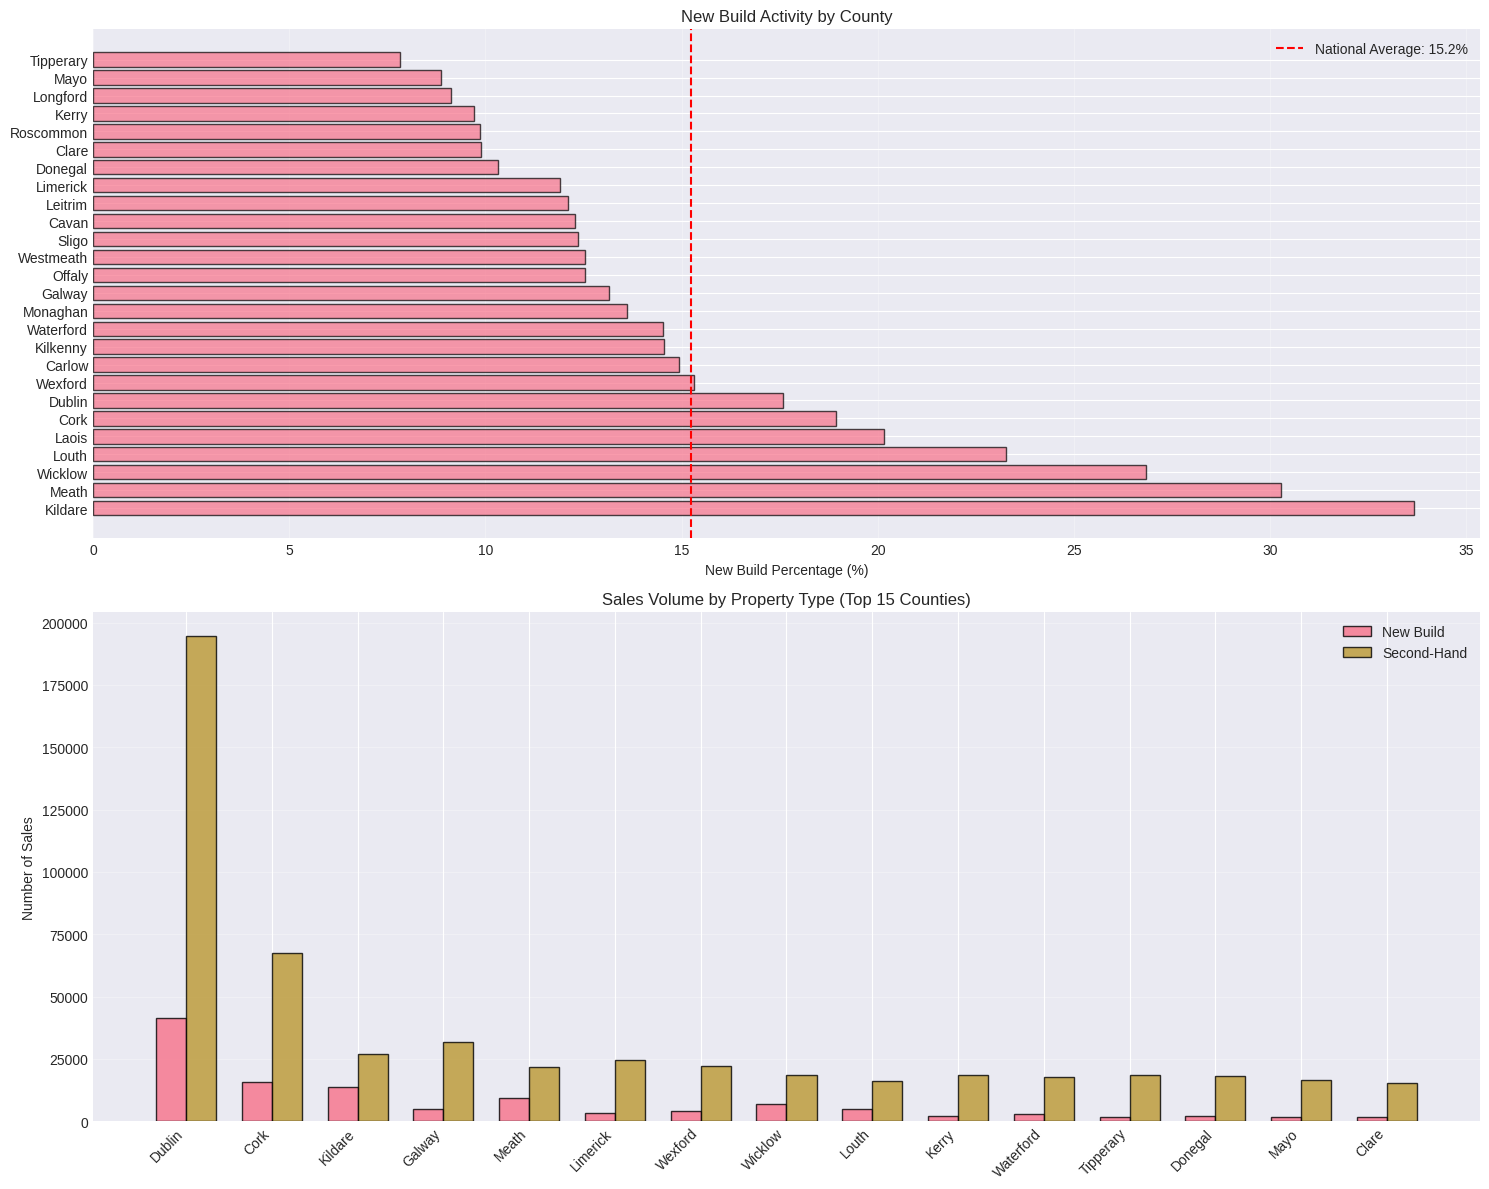

In [10]:
# Visualize county-level new build activity
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. New build percentage by county
axes[0].barh(new_build_pct.index, new_build_pct.values, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('New Build Percentage (%)')
axes[0].set_title('New Build Activity by County')
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(new_build_pct.mean(), color='red', linestyle='--', 
                label=f'National Average: {new_build_pct.mean():.1f}%')
axes[0].legend()

# 2. New build vs second-hand counts (top 15 counties by total volume)
top_counties = total_counts.nlargest(15).index
county_counts = county_pivot.loc[top_counties, 'price_eur_count'].fillna(0)

x = np.arange(len(top_counties))
width = 0.35

axes[1].bar(x - width/2, county_counts['New Build'], width, 
            label='New Build', alpha=0.8, edgecolor='black')
axes[1].bar(x + width/2, county_counts['Second-Hand'], width, 
            label='Second-Hand', alpha=0.8, edgecolor='black')
axes[1].set_ylabel('Number of Sales')
axes[1].set_title('Sales Volume by Property Type (Top 15 Counties)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_counties, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

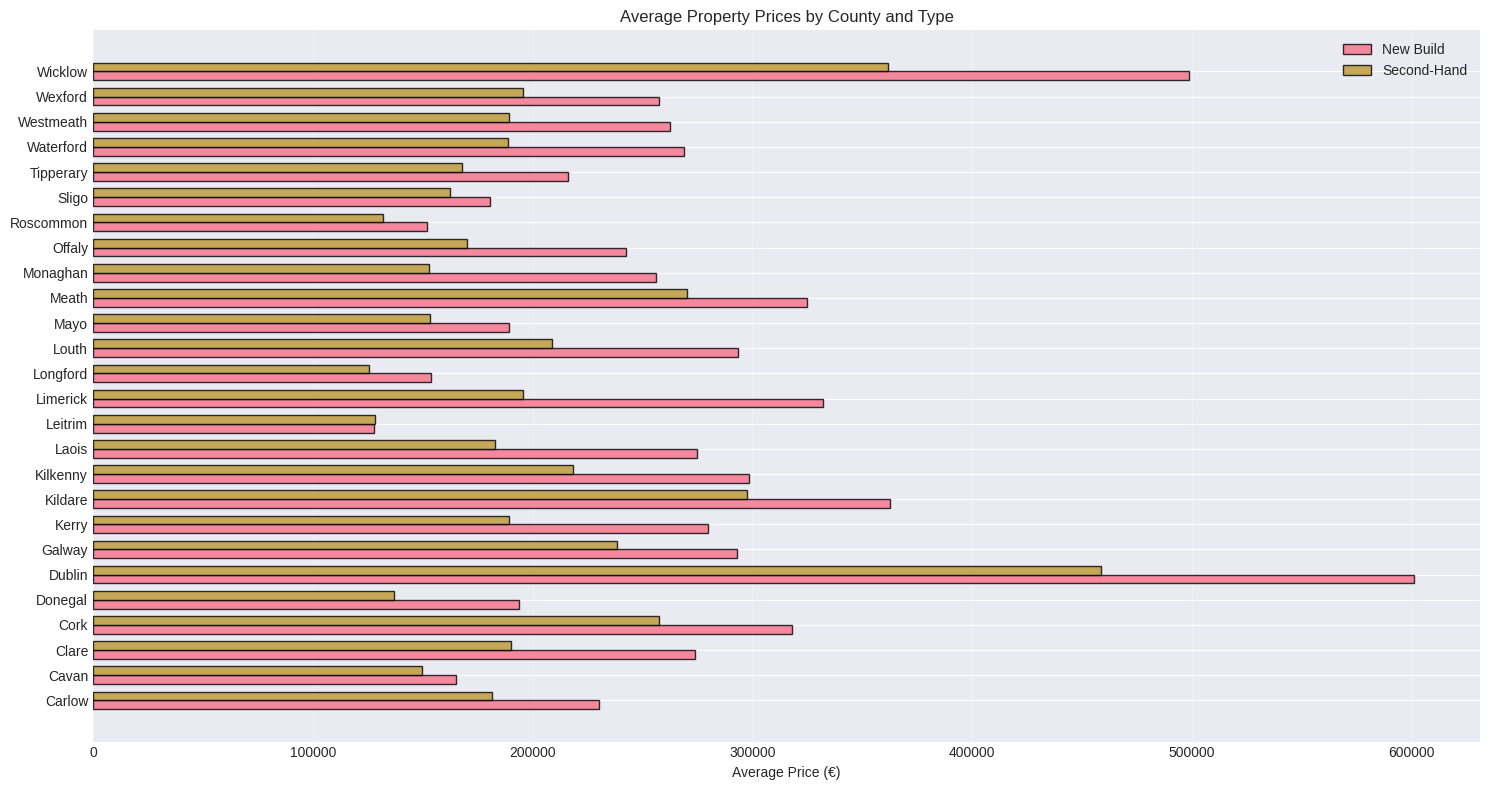

In [11]:
# County price comparison
county_prices = county_pivot['price_eur_mean'].fillna(0)

fig, ax = plt.subplots(figsize=(15, 8))

x = np.arange(len(county_prices))
width = 0.35

ax.barh(x - width/2, county_prices['New Build'], width, 
        label='New Build', alpha=0.8, edgecolor='black')
ax.barh(x + width/2, county_prices['Second-Hand'], width, 
        label='Second-Hand', alpha=0.8, edgecolor='black')

ax.set_yticks(x)
ax.set_yticklabels(county_prices.index)
ax.set_xlabel('Average Price (€)')
ax.set_title('Average Property Prices by County and Type')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Recent Trends (2020-2025)

In [12]:
# Focus on recent years
recent_df = df[df['year'] >= 2020].copy()

recent_stats = recent_df.groupby('property_type')['price_eur'].agg([
    'count', 'mean', 'median', 'std'
]).round(2)

print("\n=== Recent Market Statistics (2020-2025) ===")
print(recent_stats)

# Recent premium
recent_new = recent_stats.loc['New Build', 'mean']
recent_sh = recent_stats.loc['Second-Hand', 'mean']
recent_premium = ((recent_new - recent_sh) / recent_sh) * 100

print(f"\nRecent New Build Premium (2020-2025): {recent_premium:.2f}%")


=== Recent Market Statistics (2020-2025) ===
                count      mean    median        std
property_type                                       
New Build       65194 526555.06 343612.33 3070814.90
Second-Hand    279143 347291.37 275000.00  819878.95

Recent New Build Premium (2020-2025): 51.62%


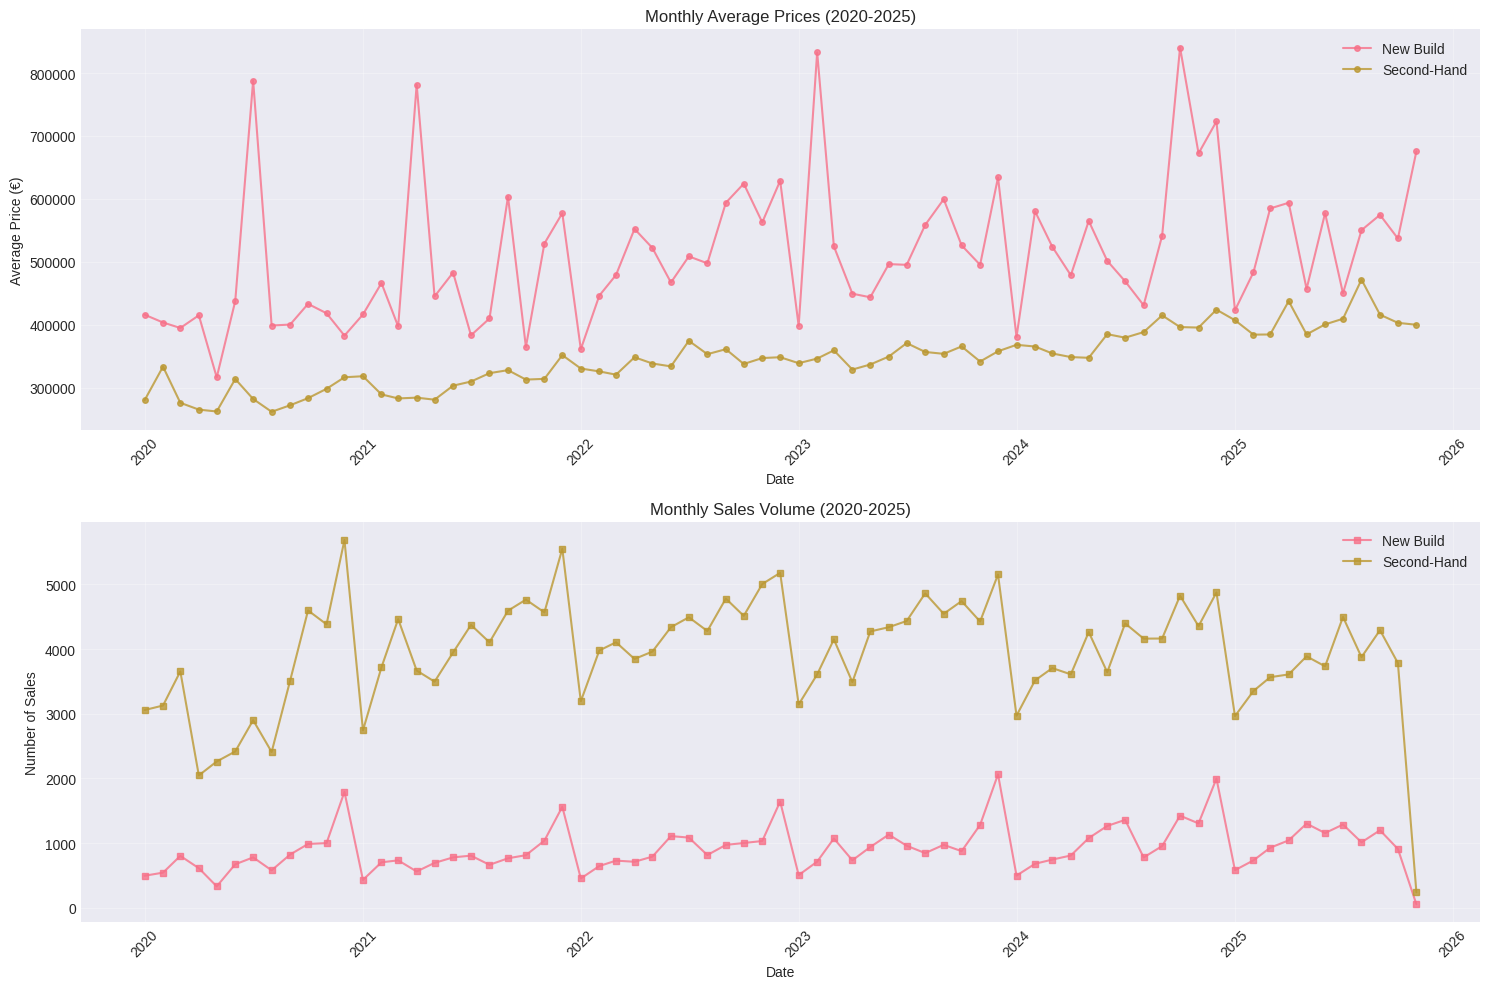

In [13]:
# Monthly trends for recent period
recent_monthly = recent_df.groupby(['year', 'month', 'property_type'])['price_eur'].agg(['mean', 'count']).reset_index()
recent_monthly['date'] = pd.to_datetime(recent_monthly[['year', 'month']].assign(day=1))

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Price trends
for ptype in ['New Build', 'Second-Hand']:
    data = recent_monthly[recent_monthly['property_type'] == ptype]
    axes[0].plot(data['date'], data['mean'], marker='o', linewidth=1.5, 
                 markersize=4, label=ptype, alpha=0.8)

axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Price (€)')
axes[0].set_title('Monthly Average Prices (2020-2025)')
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Volume trends
for ptype in ['New Build', 'Second-Hand']:
    data = recent_monthly[recent_monthly['property_type'] == ptype]
    axes[1].plot(data['date'], data['count'], marker='s', linewidth=1.5, 
                 markersize=4, label=ptype, alpha=0.8)

axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Sales')
axes[1].set_title('Monthly Sales Volume (2020-2025)')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 6. Property Size Analysis


Property Size Analysis:
                                                                 price_eur  \
                                                                     count   
property_size_category                             property_type             
greater than 125 sq metres                         New Build          6825   
greater than or equal to 125 sq metres             New Build          4615   
greater than or equal to 38 sq metres and less ... New Build         37896   
less than 38 sq metres                             New Build          3250   
n?os l? n? 38 m?adar cearnach                      New Build             1   
níos mó ná nó cothrom le 38 méadar cearnach agu... New Build             2   

                                                                            \
                                                                      mean   
property_size_category                             property_type             
greater than 125 sq metres            

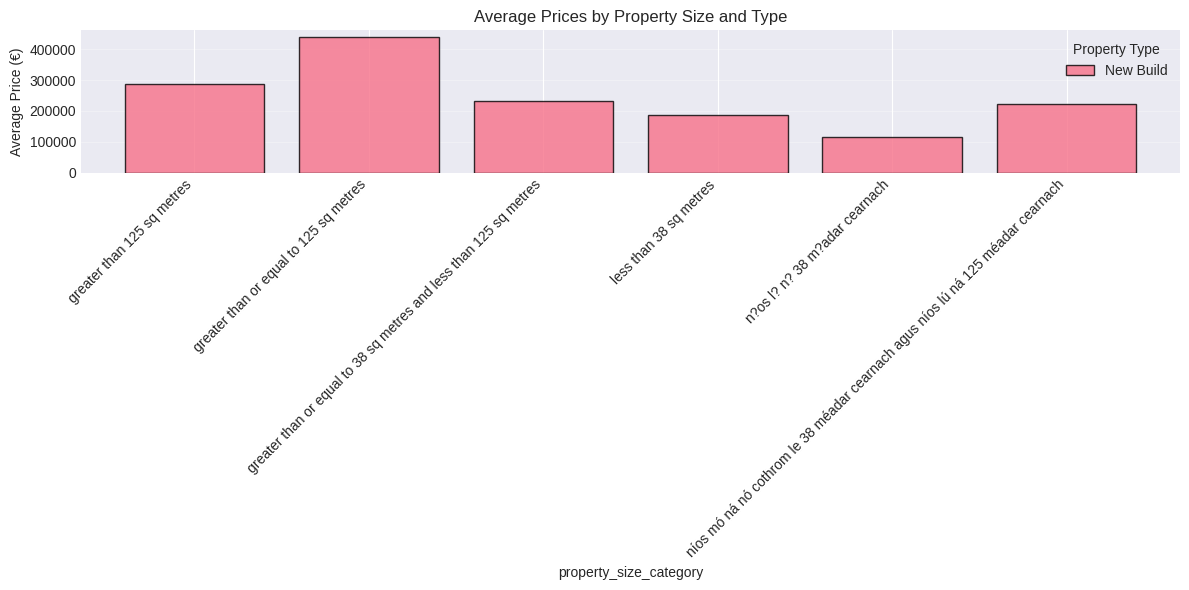

In [14]:
# Analyze by property size category
if 'property_size_category' in df.columns:
    size_analysis = df.groupby(['property_size_category', 'property_type']).agg({
        'price_eur': ['count', 'mean', 'median']
    }).round(2)
    
    print("\nProperty Size Analysis:")
    print(size_analysis)
    
    # Visualize
    size_pivot = size_analysis['price_eur']['mean'].unstack(fill_value=0)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    size_pivot.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', alpha=0.8)
    ax.set_ylabel('Average Price (€)')
    ax.set_title('Average Prices by Property Size and Type')
    ax.legend(title='Property Type')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Property size category not available in dataset")

## 7. Key Insights Summary

In [15]:
# Generate summary insights
print("\n" + "="*70)
print("KEY INSIGHTS: NEW BUILD vs SECOND-HAND PROPERTIES")
print("="*70)

# 1. Overall market split
total_sales = len(df)
new_sales = (df['property_type'] == 'New Build').sum()
sh_sales = (df['property_type'] == 'Second-Hand').sum()

print(f"\n1. MARKET COMPOSITION (2010-2025)")
print(f"   Total Sales: {total_sales:,}")
print(f"   New Builds: {new_sales:,} ({new_sales/total_sales*100:.1f}%)")
print(f"   Second-Hand: {sh_sales:,} ({sh_sales/total_sales*100:.1f}%)")

# 2. Price comparison
print(f"\n2. PRICE COMPARISON")
print(f"   New Build Average: €{price_stats.loc['New Build', 'Mean']:,.2f}")
print(f"   Second-Hand Average: €{price_stats.loc['Second-Hand', 'Mean']:,.2f}")
print(f"   Premium: {premium_pct:.2f}% (€{new_mean - sh_mean:,.2f})")

# 3. Recent trends
print(f"\n3. RECENT TRENDS (2020-2025)")
print(f"   New Build Average: €{recent_new:,.2f}")
print(f"   Second-Hand Average: €{recent_sh:,.2f}")
print(f"   Recent Premium: {recent_premium:.2f}%")

# 4. Top counties for new builds
print(f"\n4. TOP 5 COUNTIES FOR NEW BUILD ACTIVITY")
for i, (county, pct) in enumerate(new_build_pct.head(5).items(), 1):
    print(f"   {i}. {county}: {pct:.1f}%")

# 5. Market evolution
recent_market_share = market_share_pct.loc[2024, 'New Build'] if 2024 in market_share_pct.index else market_share_pct.iloc[-1]['New Build']
early_market_share = market_share_pct.iloc[0]['New Build']

print(f"\n5. MARKET EVOLUTION")
print(f"   New Build Market Share (2010): {early_market_share:.1f}%")
print(f"   New Build Market Share (2024): {recent_market_share:.1f}%")
print(f"   Change: {recent_market_share - early_market_share:+.1f} percentage points")

print("\n" + "="*70)


KEY INSIGHTS: NEW BUILD vs SECOND-HAND PROPERTIES

1. MARKET COMPOSITION (2010-2025)
   Total Sales: 752,907
   New Builds: 130,621 (17.3%)
   Second-Hand: 622,286 (82.7%)

2. PRICE COMPARISON
   New Build Average: €402,181.19
   Second-Hand Average: €290,576.32
   Premium: 38.41% (€111,604.87)

3. RECENT TRENDS (2020-2025)
   New Build Average: €526,555.06
   Second-Hand Average: €347,291.37
   Recent Premium: 51.62%

4. TOP 5 COUNTIES FOR NEW BUILD ACTIVITY
   1. Kildare: 33.7%
   2. Meath: 30.3%
   3. Wicklow: 26.8%
   4. Louth: 23.3%
   5. Laois: 20.2%

5. MARKET EVOLUTION
   New Build Market Share (2010): 25.3%
   New Build Market Share (2024): 21.0%
   Change: -4.3 percentage points



## Conclusions

This analysis reveals:

1. **Price Premium**: New builds command a premium over second-hand properties, though this varies by location and time period

2. **Market Dynamics**: The balance between new and second-hand sales has evolved over the years, reflecting construction activity and market conditions

3. **Regional Variation**: Some counties show much higher new build activity than others, indicating different levels of development

4. **Recent Trends**: The COVID-19 period and subsequent years show interesting patterns in both pricing and volume

5. **Investment Considerations**: The premium for new builds and market share trends provide valuable context for property investment decisions